### Fraudulent Transactions - Training a classifier with Sklearn

Welcome to this Jupyter Notebook in which we will train a simple classifier in Scikit Learn to detect fraudulent transactions. We will be exploring a number of libraries in Python to perform data exploration, data wrangling and data cleaning before feeding it in to a classifier of our liking. <br/>

**Note**: Before running all cells in this notebook, enter your Azure information in step 10.

Table of contents:
1. Load
2. Explore
3. Transform
4. Split the data
5. Train our model
6. Evaluate our model <br/>
    a) Accuracy <br/>
    b) Precision/Recall <br/>
    c) Confusion matrix <br/>
7. Iterate
8. Persist our model
9. Export to ONNX format <br/>
10. Deployment <br/>
11. Summary

---

#### 1. Load 
To load the data, upload your dataset in the file explorer to the right and use <br/>
pandas to load your dataset in to a dataframe

In [100]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

#### 2. Explore
Use df.info to get an overview of the datatypes and size of our dataset

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The size of dataset is: **6,362,620** rows with a total of **11 columns** <br/>
The columns step, nameOrig and nameDest contains textual features

We can use df.head to take a quick look the values in our dataset

In [102]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##### 2.2 Find missing values
We can use pandas isna (is not a number) method to determine if we have any missing values in our dataframe

In [103]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fortunately for us we do not have any missing values to address

#### 3. Transform
Before we can start to work with our data, we need to transform it to a format an algorithm can understand<br/>

Tranforming the data may include:
- Replacing any missing values, infinity or NaN
- Transforming textual features

##### 3.1 OneHotEncoding
The **nameOrig** and **nameDest** columns contain string values which we need to transform to float vectors.
But before we jump in to those columns, let's take a look at the **type** column. Given that this column has finitive options, we can use OneHotEncoding to transform the values to binary options.

Pandas provide a very useful function for this, get_dummies.<br/> 
We can utilize this function to create new binary columns.

In [104]:
df = pd.concat([df, pd.get_dummies(df['type'], prefix='type')], axis=1)
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


##### 3.2 Label Encoder
The nameOrig and nameDest columns contains a large number of permutations. OneHotEncoding could potentially create a very wide dataset, leading to out-of-memory exceptions, thus we can use something called label encoding instead to give each value a label.

Given that a fraud generally can happen to anyone, we are going to assume that nameOrig does not matter

In [105]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_cols = ["nameDest"]
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


##### 3.3 Plotting relationships

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

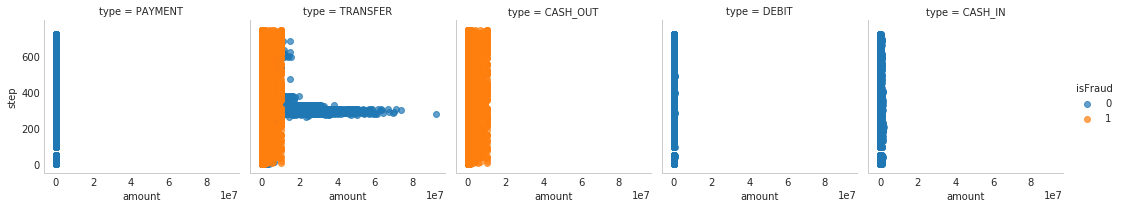

In [107]:
g = sns.FacetGrid(df, col="type", hue="isFraud")
g.map(plt.scatter, "amount", "step", alpha=.7)
g.add_legend();

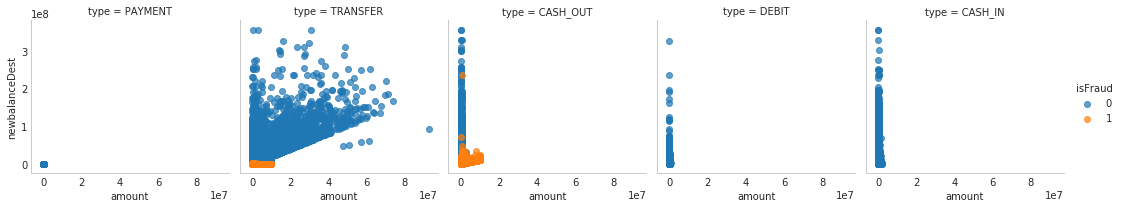

In [108]:
g = sns.FacetGrid(df, col="type", hue="isFraud")
g.map(plt.scatter, "amount", "newbalanceDest", alpha=.7)
g.add_legend();

Interestingly **newbalanceDest** and **amount** do not correlate as we expect for fraudulent cases. <br/> Many fraudulent cases appears to involve small amounts but also render the destination account with none or very little money

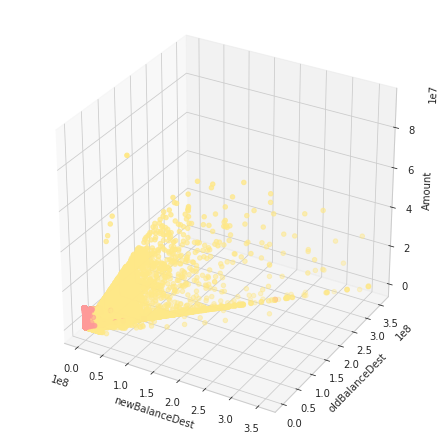

In [109]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))
fill_colors = ['#FF9999' if wt==1 else '#FFE888' for wt in list(df['isFraud'])]

ax = Axes3D(fig) # Method 1

ax.scatter(df['newbalanceDest'], df['oldbalanceDest'], df['amount'], c=fill_colors, marker='o')
ax.set_xlabel('newBalanceDest')
ax.set_ylabel('oldBalanceDest')
ax.set_zlabel('Amount')

plt.show()

It surely seems like we may be able to create some kind of separation using these columns. Let's create variables holding the features and labels.

In [111]:
X = df[["amount", "newbalanceDest", "oldbalanceDest", "newbalanceOrig", "oldbalanceOrg", "nameDest", "type_CASH_IN", "type_CASH_OUT", "type_DEBIT", "type_PAYMENT", "type_TRANSFER"]]
Y = df["isFraud"]

#### 4. Split the data
To evaluate the performance of the model, we will need a dataset for training and one for testing

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train.shape

(4262955, 11)

#### 5. Train our model
Our data is now clean and in the correct format to be fed in to a machine learning algorithm.
For this example we'll use an ensemble algorithm consisting of number of decision trees <br/>
The random forest classifier will in our case create 100 decision trees, with a max depth of 2.

In [113]:
Y_train = Y_train.values.flatten()
Y_test = Y_test.values.flatten()

In [114]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### 6. Evaluate our model
Before we can put our model to use, we'll need to know how good it is.

##### 6.1 Accuracy
We can use the classifers score() method with the test dataset to determine the accuracy.

In [115]:
metrics = clf.score(X_test, Y_test)

print(metrics)

0.99873027363889



Not bad, an accuracy of **99.9%**! <br/> 
However, if you recall, our dataset was highly unbalanced and if we just guessed non-fraudulent for all transactions we would also achieve this accuracy. Are there any other metrics we can use?

##### 6.2 Precision-Recall

- **Precision**: High precision means that all transactions we flagged as fraudulent actually were (no false positives)
- **Recall**: High recall means that we did not miss any fraudulent transactions (no false negatives)

It's difficult to achieve a high value for both. In our case, it would make the most sense to have a high recall, as it is more important to not miss any fraudulent transactions than to flag a couple of non-fraudulent cases as fraudulent <br/>

In [116]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred = clf.predict(X_test)
print(classification_report(Y_test,pred, target_names=target_names))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

non-fraudulent       1.00      1.00      1.00   2096999
    fraudulent       0.00      0.00      0.00      2666

     micro avg       1.00      1.00      1.00   2099665
     macro avg       0.50      0.50      0.50   2099665
  weighted avg       1.00      1.00      1.00   2099665



/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As the report indicates, the precision is good for non-fraudulent cases.<br/> 
However, our **recall for fraudulent cases is 0**, meaning that we miss all fraudulent cases. 
Although we don't have any false positives, non of our customers fraudulent transactions are beight caught

If we look at the precision-recall curve, we see that the curve is pushed against the left, when we actually want it towards the right

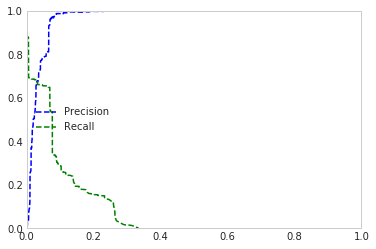

In [117]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

##### 6.3 Confusion matrix
To further explore the ratio between false positives, false negatives, true positives and true negatives, we can have a look at the confusion matrix.

In [118]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names =  ['Non-fraudulent', 'Fraudulent']


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


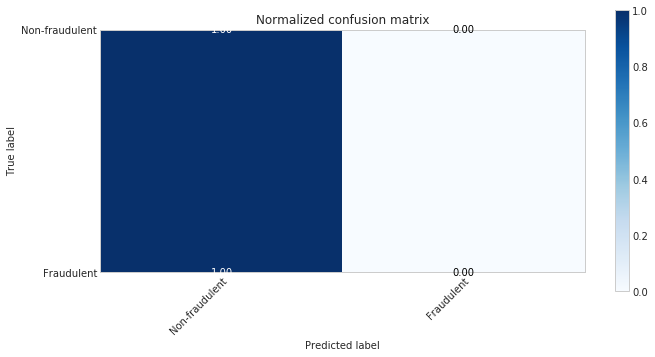

In [119]:
plot_confusion_matrix(Y_test, pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The confusion matrix tells us that we marked all fraudulent cases as non-fraudulent, not great.

#### 7. Iterate
So our model is far from great, let's see if we can improve it. 
One of the issues we are seeing right now is that despite it's accuracy, it is missing a lot of fraudulent transactions.
A struggle we have is that our dataset is highly imbalanced. We can address this by weighing our inputs

Let's train our model again, but boosting our minority class, is fraudulent

In [120]:
from sklearn.ensemble import RandomForestClassifier

clf_with_weights = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight="balanced")
clf_with_weights.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [121]:
metrics = clf_with_weights.score(X_test, Y_test)

print(metrics)

0.9485408386575954


Our accuarcy dropped to **94.9%**, but let's see if we can outweight that with better recall-precision

In [122]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred_with_weights = clf_with_weights.predict(X_test)
print(classification_report(Y_test, pred_with_weights, target_names=target_names))

                precision    recall  f1-score   support

non-fraudulent       1.00      0.95      0.97   2096999
    fraudulent       0.02      0.92      0.04      2666

     micro avg       0.95      0.95      0.95   2099665
     macro avg       0.51      0.94      0.51   2099665
  weighted avg       1.00      0.95      0.97   2099665



Wow! We can see that especially recall greatly increased for the fraudulent cases, meaning that we miss a lot less false negatives

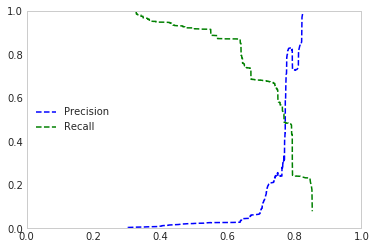

In [123]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf_with_weights.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

##### Confusion matrix
Let's explore the confusion matrix for our new model

Normalized confusion matrix
[[0.95 0.05]
 [0.08 0.92]]


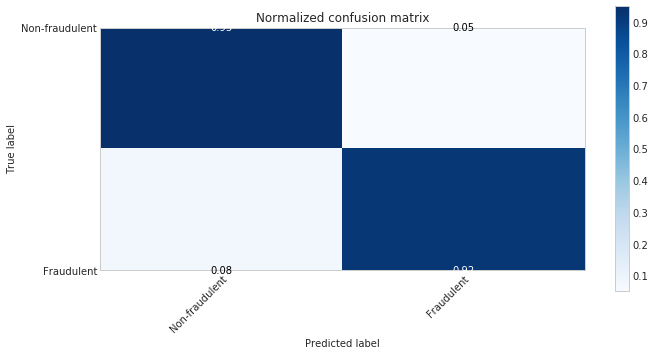

In [124]:
plot_confusion_matrix(Y_test, pred_with_weights, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Much better. Although not perfect we see that only 8% of fraudulent cases are missed and marked as non-fraudulent. Similarly we mark 5% as fraudulent while they are not

#### 8. Persist our model
There are multiple ways in which we can persist our trained model. 
Let's look at using both scikit learn as well as Azure's Python SDK to do so

- Using Scikit Learn

In [125]:
from sklearn.externals import joblib
joblib.dump(value=clf_with_weights, filename="fraudulent-classifier.pkl")

['fraudulent-classifier.pkl']

- Using Azure's Python SDK

In [126]:
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.get(name="", subscription_id='', resource_group='')
model = Model.register(workspace=ws, model_path="fraudulent-classifier.pkl", model_name="fraudulent-jupyter-model")

Registering model fraudulent-jupyter-model


#### 9. ONNX Format
The Open Neural Exchange Format (ONNX) allows models trained in different libraries to be loaded and used in others.
ONNX is fully backed by Google, Facebook and Microsoft. Models trained in Python, e.g. using SciKitLearn or PyTorch can be exported to an ONNX format and imported and consumed by ML.NET

In [127]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, X_train.shape[1]]))]
onx = convert_sklearn(clf_with_weights, initial_types=initial_type)
with open("fraudulent-classifier-jupyter.onnx", "wb") as f:
    f.write(onx.SerializeToString())

WARNING - The maximum opset needed by this model is only 1.
WARNING - The maximum opset needed by this model is only 9.


#### 10. Deployment 
The final piece is to deploy our model to production so that we can use it to make accurate predictions.
To be able to deploy our model, we will first need to create a Docker image for deployment. The image requireses two components <br/>

1. score.py -> loads the prediction engine
2. conda.yml -> defines the requires dependencies

The image can then be deployed to a running machine

##### 10.1 Image creation

In [128]:
#Create conda file
from azureml.core.conda_dependencies import CondaDependencies

fraudulentenv = CondaDependencies()
fraudulentenv.add_conda_package("scikit-learn")
 
with open("fraudulentenv.yml","w") as f:
    f.write(fraudulentenv.serialize_to_string())
with open("fraudulentenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- conda-forge



In [129]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('fraudulent-jupyter-model')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prbediction
    y_hat = model.predict(data)
    return json.dumps(y_hat.tolist())

Overwriting score.py


##### 10.2 Deployment

We can tie altogether and create our Docker image as well as deploy it running service

In [130]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="fraudulentenv.yml")

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"method" : "sklearn"}, 
                                               description='Predict fraudulent transactions')

service = Webservice.deploy_from_model(workspace=ws,
                                       name='fraudulent-transactions-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="fraudulentenv.yml")

Creating image
Running..............................
Succeeded
Image creation operation finished for image fraudulent-transactions-svc:5, operation "Succeeded"
Creating service
Running.............
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 441 ms, sys: 97.9 ms, total: 539 ms
Wall time: 3min 39s


##### 10.3 Predict
To tie it altogheter, we can call our end-point with data to determine if this transaction is fraudulent or not

In [131]:
print(service.scoring_uri)

http://2f59f547-0890-44c4-a666-776e8ba9ce1b.southcentralus.azurecontainer.io/score


In [136]:
!curl -X POST \
    -H 'Content-Type':'application/json' \
    -d '{"data": [[181.0, 0, 0, 0, 181.0, 439685, 0, 0, 0, 0, 1]]  }' \
    http://2f59f547-0890-44c4-a666-776e8ba9ce1b.southcentralus.azurecontainer.io/score

"[1]"

**Note** that we had to pass in already transformed data to our model. For real production use there are multiple ways we can go about this <br/>

1. Create our own class to do pre-processing similar to what we did when we created the model
2. Use Sklearn pipelines instead, build the transformation in to the pipeline and call pipeline.fit() on the incoming data before the prediction

### 11. Summary
This Notebook has demonstrated how you can build your own classifier using Python open-source libraries such as Pandas, ScikitLearn and Numpy in a Jupyter VM in Azure Machine Learning Service.
As we can see, finding a good algorithm and fine-tunning its hyper-parameters can be complicated, but working with the notebook makes the work structured and easy to repeat